### IBM AutoAI-SDK Auto-Generated Notebook v1.13.1

**Note:** Notebook code generated using AutoAI will execute successfully. If code is modified or reordered,   
there is no guarantee it will successfully execute. This pipeline is optimized for the original dataset.  
The pipeline may fail or produce sub-optimium results if used with different data. For different data,  
please consider returning to AutoAI Experiments to generate a new pipeline. Please read our documentation   
for more information:   
<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>  


Before modifying the pipeline or trying to re-fit the pipeline, consider:   
The notebook converts dataframes to numpy arrays before fitting the pipeline   
(a current restriction of the preprocessor pipeline). The known_values_list is passed by reference   
and populated with categorical values during fit of the preprocessing pipeline. Delete its members before re-fitting.

<a id="content"></a>
## Notebook content

This notebook contains steps and code to demonstrate AutoAI pipeline. This notebook introduces commands for getting data,  
pipeline model, model inspection and testing.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Notebook goals

-  inspection of trained pipeline via graphical vizualization and source code preview
-  pipeline evaluation
-  pipeline deployment and webservice scoring.

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)         
    a.  [AutoAI experiment metadata](#variables_definition)      
2.	[Pipeline inspection](#inspection)      
    a.  [Get historical optimizer instance](#get_hist_and_train)      
    b.  [Get pipeline model](#get_pipeline)      
    c.  [Preview pipeline model as python code](#preview_model_to_python_code)      
    d.  [Visualize pipeline model](#visualize_pipeline)      
    e.  [Read training data](#train_read)        
    f.  [Test pipeline model locally](#test_model)       
3.	[Pipeline refinery and testing (optional)](#refinery)  
    a.  [Pipeline definition source code](#pipeline_definition)      
    b.  [Lale library](#lale_library)      
4.	[Deploy and score](#scoring)       
    a.  [Insert WML credentials](#wml_credentials)   
    b.  [Create deployment](#deployment)      
    c.  [Score webservice](#online_scoring)        
    d.  [Delete deployment](#delete_deployment)       
5.  [Authors](#authors)      

<a id="setup"></a>
# Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
 - `watson-machine-learning-client` uninstallation of the old client
 - `ibm_watson_machine_learning` installation
 - `autoai-libs` installation/upgrade
 - `lightgbm` or `xgboost` installation/downgrade if they are needed.

In [1]:
!pip uninstall watson-machine-learning-client -y

Uninstalling watson-machine-learning-client-1.0.382:
  Successfully uninstalled watson-machine-learning-client-1.0.382


In [2]:
!pip install -U ibm-watson-machine-learning

     |████████████████████████████████| 1.5MB 10.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 29.2MB/s eta 0:00:01
     |████████████████████████████████| 829kB 42.6MB/s eta 0:00:01
     |████████████████████████████████| 143kB 49.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a7/10/5b/5d6543382dc5cc86022e490619c8db1253c22d50a57493262b
  Stored in directory: /home/dsxuser/.cache/pip/wheels/4d/69/e0/048f98aadb8f018f13fde51c52af878763eed47d2ee0fb735d
  Stored in directory: /home/dsxuser/.cache/pip/wheels/44/90/ce/c4fa6f55d3c3cfd1f824f31585c58cd717ef035a63620e7ba7
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3transfer
  Found existing installation: ibm-cos-sdk-core 2.6.0
    Uninstalling ibm-cos-sdk-core-2.6.0:
      Successfully uninstalled ibm-cos-sdk-core-2.6.0
  Found existing installation: ibm-cos-sdk-s3transfer 2.6.0
    Uninstalling ibm-cos-sdk-s3transfer-2.6.0:
      Successfully uninstalled ibm-cos-sdk-s3transfer-2.6.0
 

In [3]:
!pip install -U autoai-libs
!pip install -U xgboost==0.90

     |████████████████████████████████| 4.1MB 9.7MB/s eta 0:00:01
     |████████████████████████████████| 14.5MB 48.6MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 45.8MB/s eta 0:00:01    |█████████████████████████▏      | 8.2MB 45.8MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
  Found existing installation: autoai-libs 1.10.5
    Uninstalling autoai-libs-1.10.5:
      Successfully uninstalled autoai-libs-1.10.5
     |████████████████████████████████| 142.8MB 53.5MB/s eta 0:00:01     |████████████████████████████▊   | 128.1MB 53.5MB/s eta 0:00:01


<a id="variables_definition"></a>
### AutoAI experiment metadata

This cell defines COS credentials required to retrieve AutoAI pipeline.

In [4]:
# @hidden_cell
from ibm_watson_machine_learning.helpers import DataConnection, S3Connection, S3Location

training_data_reference = [DataConnection(
    connection=S3Connection(
        api_key='',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
        location=S3Location(
        bucket='autoaitutorial-donotdelete-pr-nenyyyoctiyrdu',
        path='german_credit_data.csv'
    ))
]
training_result_reference = DataConnection(
    connection=S3Connection(
        api_key='',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
    location=S3Location(
        bucket='autoaitutorial-donotdelete-pr-nenyyyoctiyrdu',
        path='auto_ml/f8d70dd9-9fda-43e9-a3d7-06f4d4f62104/wml_data/78a6bf28-a0ec-451e-bdf6-7c75b6b4fae6/data/automl',
        model_location='auto_ml/f8d70dd9-9fda-43e9-a3d7-06f4d4f62104/wml_data/78a6bf28-a0ec-451e-bdf6-7c75b6b4fae6/data/automl/hpo_c_output/Pipeline1/model.pickle',
        training_status='auto_ml/f8d70dd9-9fda-43e9-a3d7-06f4d4f62104/wml_data/78a6bf28-a0ec-451e-bdf6-7c75b6b4fae6/training-status.json'
    ))

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio

In [5]:
experiment_metadata = dict(
   prediction_type='classification',
   prediction_column='Result',
   test_size=0.1,
   scoring='accuracy',
   project_id='4e435770-8231-4430-80ef-e2d86b1b4bb8',
   deployment_url='https://us-south.ml.cloud.ibm.com',
   csv_separator=',',
   random_state=33,
   excel_sheet=0,
   max_number_of_estimators=2,
   training_data_reference = training_data_reference,
   training_result_reference = training_result_reference)

pipeline_name='Pipeline_4'

<a id="inspection"></a>
## Pipeline inspection
In this section you will get the trained pipeline model from the AutoAI experiment and inspect it.  
You will see pipeline as a pythone code, graphically visualized and at the end, you will perform a local test.


<a id="get_hist_and_train"></a>
### Get historical optimizer instance

The next cell contains code for retrieving fitted optimizer.

In [6]:
from ibm_watson_machine_learning.experiment import AutoAI

optimizer = AutoAI().runs.get_optimizer(metadata=experiment_metadata)

<a id="get_pipeline"></a>
### Get pipeline model

The following cell loads selected AutoAI pipeline model. If you want to get pure scikit-learn pipeline specify `as_type='sklearn'` parameter. By default enriched scikit-learn pipeline is returned `as_type='lale'`.

In [7]:
pipeline_model = optimizer.get_pipeline(pipeline_name=pipeline_name)

<a id="preview_model_to_python_code"></a>
### Preview pipeline model as python code
In the next cell, downloaded pipeline model could be previewed as a python code.  
You will be able to see what exact steps are involved in model creation.

In [8]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from lale.operators import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from lale.operators import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TA1
import autoai_libs.utils.fc_methods
from autoai_libs.cognito.transforms.transform_utils import FS1
from autoai_libs.cognito.transforms.transform_utils import TA2
from xgboost import XGBClassifier

numpy_column_selector_0 = NumpyColumnSelector(
    columns=[
        0,
        1,
        2,
        3,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
    ]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str",
        "int_num",
        "char_str",
        "char_str",
        "char_str",
        "char_str",
        "int_num",
        "char_str",
        "char_str",
        "int_num",
        "char_str",
        "int_num",
        "char_str",
        "char_str",
        "int_num",
        "char_str",
        "int_num",
        "char_str",
        "char_str",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
    ],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    filling_values=float("nan"), missing_values=[]
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
    ],
    known_values_list=[
        [
            325555860170934234154699000303056387163,
            15383329390723917820095052430123158390,
            323477181110618013028966518905470885308,
            90027146220922640916088329682413202194,
        ],
        [
            4,
            5,
            6,
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            16,
            18,
            20,
            21,
            22,
            24,
            26,
            27,
            28,
            30,
            33,
            36,
            39,
            40,
            42,
            45,
            48,
            54,
            60,
            72,
        ],
        [
            38986445549542442321557191447025866156,
            267937538446506719991113840686643945948,
            263074127556784887061410864062719039337,
            313395741992388816259801026371593295538,
            97098653596028982752579736902392580610,
        ],
        [
            188774133412089013334168317108145522314,
            339133984977878355842290532697332758920,
            264549808426721267187442848777517807079,
            313862497436965369184071736635331226312,
            49380184081525735282760804114691827473,
            32921757557247643282888578958001078124,
            184043648558321368719192779459340770899,
            40356322633887638017572702126324434127,
            27066543874196452665584080672016050673,
            217923705287528350213375664650766903129,
        ],
        [
            25434723854676870941572087954235909590,
            264887831026003896438256129430322505664,
            145436806478180957898394582931959476854,
            136263187768159424512939709921692513169,
            121562539544909599559795619680708069811,
        ],
        [
            193141939139192470599492223035323867483,
            7923680490995496141761354831548369207,
            233248167097859821028607209559961158515,
            19796353033582849065230891941343294866,
            291476772992552972919661507593271470129,
        ],
        [1, 2, 3, 4],
        [
            160619929502074120616596445597750633873,
            238701477379022787593423349087690538549,
            16022085970252760596108299312348105311,
            154618934012261516341348801021991647341,
        ],
        [
            31012945666714526729717789524913102448,
            83473034449197679647193223685460733254,
            47225727642516714025624712225770002715,
        ],
        [1, 2, 3, 4],
        [
            103590596937691349480514195289963979913,
            116334392175581151182728419027947770193,
            260210605759544941560617293301260835595,
            220531445913466298672475250687443822753,
        ],
        [
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            29,
            30,
            31,
            32,
            33,
            34,
            35,
            36,
            37,
            38,
            39,
            40,
            41,
            42,
            43,
            44,
            45,
            46,
            47,
            48,
            49,
            50,
            51,
            52,
            53,
            54,
            55,
            56,
            57,
            58,
            59,
            60,
            61,
            62,
            63,
            64,
            65,
            66,
            67,
            68,
            70,
            74,
            75,
        ],
        [
            257957329748473654629366780296612045643,
            336329862108626423632309219946381255267,
            338244089769250393003773394868854440202,
        ],
        [
            256309873132230630010165208530446309251,
            323911116871606892129930442158714138536,
            111131217018351816715545828292639534535,
        ],
        [1, 2, 3, 4],
        [
            339000043487330592624113155342866255944,
            132154501355838652605061697785341694995,
            40817249923119934392146187982203627141,
            89407784426558061856363805348213595548,
        ],
        [1, 2],
        [
            197077289172123987968528914612888320836,
            12834886505549368140196851667829839472,
        ],
        [
            249448558415736823753944795873265402684,
            250375873908432057002922575397908383694,
        ],
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    missing_values=float("nan"),
    sklearn_version_family="20",
    strategy="most_frequent",
)
cat_encoder = CatEncoder(
    dtype=np.float64, handle_unknown="error", sklearn_version_family="20"
)
pipeline_0 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(
    dtypes_list=["int_num"], missing_values_reference_list=[]
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    filling_values=float("nan"), missing_values=[]
)
num_imputer = NumImputer(missing_values=float("nan"), strategy="median")
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_1 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        0,
        1,
        2,
        3,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        4,
    ],
)
ta1_0 = TA1(
    fun=np.tan,
    name="tan",
    datatypes=["float"],
    feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "Check_Account ",
        "Duration",
        "Credit_history",
        "Purpose",
        "Credit amount ",
        "Saving_account",
        "Employment",
        "Install_rate",
        "Personal_status",
        "Other_debrotors",
        "Present_residence",
        "Property",
        "Age",
        "Installment_plant",
        "Housing",
        "Num_credits",
        "Job",
        "Num_dependents",
        "Telephone",
        "Foreign",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_0 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta1_1 = TA1(
    fun=np.square,
    name="square",
    datatypes=["numeric"],
    feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "Check_Account ",
        "Duration",
        "Credit_history",
        "Purpose",
        "Credit amount ",
        "Saving_account",
        "Employment",
        "Install_rate",
        "Personal_status",
        "Other_debrotors",
        "Present_residence",
        "Property",
        "Age",
        "Installment_plant",
        "Housing",
        "Num_credits",
        "Job",
        "Num_dependents",
        "Telephone",
        "Foreign",
        "tan(Duration)",
        "tan(Credit amount )",
        "tan(Age)",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_1 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta2 = TA2(
    fun=np.multiply,
    name="product",
    datatypes1=[
        "intc",
        "intp",
        "int_",
        "uint8",
        "uint16",
        "uint32",
        "uint64",
        "int8",
        "int16",
        "int32",
        "int64",
        "short",
        "long",
        "longlong",
        "float16",
        "float32",
        "float64",
    ],
    feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical],
    datatypes2=[
        "intc",
        "intp",
        "int_",
        "uint8",
        "uint16",
        "uint32",
        "uint64",
        "int8",
        "int16",
        "int32",
        "int64",
        "short",
        "long",
        "longlong",
        "float16",
        "float32",
        "float64",
    ],
    feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "Check_Account ",
        "Duration",
        "Credit_history",
        "Purpose",
        "Credit amount ",
        "Saving_account",
        "Employment",
        "Install_rate",
        "Personal_status",
        "Other_debrotors",
        "Present_residence",
        "Property",
        "Age",
        "Installment_plant",
        "Housing",
        "Num_credits",
        "Job",
        "Num_dependents",
        "Telephone",
        "Foreign",
        "tan(Duration)",
        "tan(Credit amount )",
        "tan(Age)",
        "square(Duration)",
        "square(Credit amount )",
        "square(Age)",
        "square(tan(Duration))",
        "square(tan(Credit amount ))",
        "square(tan(Age))",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_2 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
xgb_classifier = XGBClassifier(
    gamma=0.8496593520679786,
    learning_rate=0.031397686095336205,
    max_depth=20,
    min_child_weight=2,
    missing=float("nan"),
    n_estimators=1017,
    n_jobs=2,
    random_state=33,
    reg_alpha=0.48852952080384837,
    reg_lambda=0.8217033834592385,
    silent=True,
    subsample=0.8313688672382262,
    verbosity=0,
    tree_method="hist",
)
pipeline = make_pipeline(
    union,
    numpy_permute_array,
    ta1_0,
    fs1_0,
    ta1_1,
    fs1_1,
    ta2,
    fs1_2,
    xgb_classifier,
)
```

<a id="visualize_pipeline"></a>
### Visualize pipeline model

Preview pipeline model stages as graph. Each node's name links to detailed description of the stage.


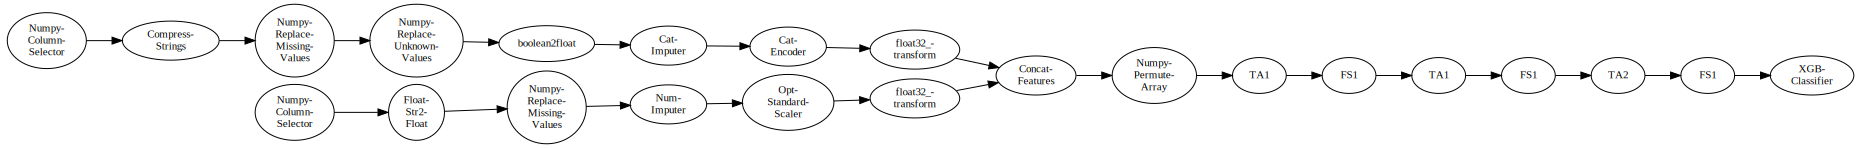

In [9]:
pipeline_model.visualize()

<a id="train_read"></a>
### Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [10]:
train_df = optimizer.get_data_connections()[0].read()
test_df = train_df.sample(n=5).drop([experiment_metadata['prediction_column']], axis=1)

<a id="test_model"></a>
### Test pipeline model locally
You can predict target value using trained AutoAI model by calling `predict()`.

In [11]:
y_pred = pipeline_model.predict(test_df.values)
print(y_pred)

[2 1 1 1 1]


<a id="refinery"></a>
## Pipeline refinery and testing (optional)

In this section you will learn how to refine and retrain the best pipeline returned by AutoAI.
It can be performed by:
 - modifying pipeline definition source code
 - using [lale](https://lale.readthedocs.io/en/latest/) library for semi-automated data science

**Note**: In order to run this section change following cells to 'code' cell.

<a id="pipeline_definition"></a>
### Pipeline definition source code
Following cell lets you experiment with pipeline definition in python, e.g. change steps parameters.

It will inject pipeline definition to the next cell.

In [12]:
pipeline_model.pretty_print(combinators=False, ipython_display='input')

In [ ]:
# generated by pretty_print(ipython_display='input') from previous cell
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from lale.operators import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from lale.operators import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TA1
import autoai_libs.utils.fc_methods
from autoai_libs.cognito.transforms.transform_utils import FS1
from autoai_libs.cognito.transforms.transform_utils import TA2
from xgboost import XGBClassifier

numpy_column_selector_0 = NumpyColumnSelector(
    columns=[
        0,
        1,
        2,
        3,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
    ]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str",
        "int_num",
        "char_str",
        "char_str",
        "char_str",
        "char_str",
        "int_num",
        "char_str",
        "char_str",
        "int_num",
        "char_str",
        "int_num",
        "char_str",
        "char_str",
        "int_num",
        "char_str",
        "int_num",
        "char_str",
        "char_str",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
    ],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    filling_values=float("nan"), missing_values=[]
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
    ],
    known_values_list=[
        [
            325555860170934234154699000303056387163,
            15383329390723917820095052430123158390,
            323477181110618013028966518905470885308,
            90027146220922640916088329682413202194,
        ],
        [
            4,
            5,
            6,
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            16,
            18,
            20,
            21,
            22,
            24,
            26,
            27,
            28,
            30,
            33,
            36,
            39,
            40,
            42,
            45,
            48,
            54,
            60,
            72,
        ],
        [
            38986445549542442321557191447025866156,
            267937538446506719991113840686643945948,
            263074127556784887061410864062719039337,
            313395741992388816259801026371593295538,
            97098653596028982752579736902392580610,
        ],
        [
            188774133412089013334168317108145522314,
            339133984977878355842290532697332758920,
            264549808426721267187442848777517807079,
            313862497436965369184071736635331226312,
            49380184081525735282760804114691827473,
            32921757557247643282888578958001078124,
            184043648558321368719192779459340770899,
            40356322633887638017572702126324434127,
            27066543874196452665584080672016050673,
            217923705287528350213375664650766903129,
        ],
        [
            25434723854676870941572087954235909590,
            264887831026003896438256129430322505664,
            145436806478180957898394582931959476854,
            136263187768159424512939709921692513169,
            121562539544909599559795619680708069811,
        ],
        [
            193141939139192470599492223035323867483,
            7923680490995496141761354831548369207,
            233248167097859821028607209559961158515,
            19796353033582849065230891941343294866,
            291476772992552972919661507593271470129,
        ],
        [1, 2, 3, 4],
        [
            160619929502074120616596445597750633873,
            238701477379022787593423349087690538549,
            16022085970252760596108299312348105311,
            154618934012261516341348801021991647341,
        ],
        [
            31012945666714526729717789524913102448,
            83473034449197679647193223685460733254,
            47225727642516714025624712225770002715,
        ],
        [1, 2, 3, 4],
        [
            103590596937691349480514195289963979913,
            116334392175581151182728419027947770193,
            260210605759544941560617293301260835595,
            220531445913466298672475250687443822753,
        ],
        [
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            29,
            30,
            31,
            32,
            33,
            34,
            35,
            36,
            37,
            38,
            39,
            40,
            41,
            42,
            43,
            44,
            45,
            46,
            47,
            48,
            49,
            50,
            51,
            52,
            53,
            54,
            55,
            56,
            57,
            58,
            59,
            60,
            61,
            62,
            63,
            64,
            65,
            66,
            67,
            68,
            70,
            74,
            75,
        ],
        [
            257957329748473654629366780296612045643,
            336329862108626423632309219946381255267,
            338244089769250393003773394868854440202,
        ],
        [
            256309873132230630010165208530446309251,
            323911116871606892129930442158714138536,
            111131217018351816715545828292639534535,
        ],
        [1, 2, 3, 4],
        [
            339000043487330592624113155342866255944,
            132154501355838652605061697785341694995,
            40817249923119934392146187982203627141,
            89407784426558061856363805348213595548,
        ],
        [1, 2],
        [
            197077289172123987968528914612888320836,
            12834886505549368140196851667829839472,
        ],
        [
            249448558415736823753944795873265402684,
            250375873908432057002922575397908383694,
        ],
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    missing_values=float("nan"),
    sklearn_version_family="20",
    strategy="most_frequent",
)
cat_encoder = CatEncoder(
    dtype=np.float64, handle_unknown="error", sklearn_version_family="20"
)
pipeline_0 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(
    dtypes_list=["int_num"], missing_values_reference_list=[]
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    filling_values=float("nan"), missing_values=[]
)
num_imputer = NumImputer(missing_values=float("nan"), strategy="median")
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_1 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        0,
        1,
        2,
        3,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        4,
    ],
)
ta1_0 = TA1(
    fun=np.tan,
    name="tan",
    datatypes=["float"],
    feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "Check_Account ",
        "Duration",
        "Credit_history",
        "Purpose",
        "Credit amount ",
        "Saving_account",
        "Employment",
        "Install_rate",
        "Personal_status",
        "Other_debrotors",
        "Present_residence",
        "Property",
        "Age",
        "Installment_plant",
        "Housing",
        "Num_credits",
        "Job",
        "Num_dependents",
        "Telephone",
        "Foreign",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_0 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta1_1 = TA1(
    fun=np.square,
    name="square",
    datatypes=["numeric"],
    feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "Check_Account ",
        "Duration",
        "Credit_history",
        "Purpose",
        "Credit amount ",
        "Saving_account",
        "Employment",
        "Install_rate",
        "Personal_status",
        "Other_debrotors",
        "Present_residence",
        "Property",
        "Age",
        "Installment_plant",
        "Housing",
        "Num_credits",
        "Job",
        "Num_dependents",
        "Telephone",
        "Foreign",
        "tan(Duration)",
        "tan(Credit amount )",
        "tan(Age)",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_1 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta2 = TA2(
    fun=np.multiply,
    name="product",
    datatypes1=[
        "intc",
        "intp",
        "int_",
        "uint8",
        "uint16",
        "uint32",
        "uint64",
        "int8",
        "int16",
        "int32",
        "int64",
        "short",
        "long",
        "longlong",
        "float16",
        "float32",
        "float64",
    ],
    feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical],
    datatypes2=[
        "intc",
        "intp",
        "int_",
        "uint8",
        "uint16",
        "uint32",
        "uint64",
        "int8",
        "int16",
        "int32",
        "int64",
        "short",
        "long",
        "longlong",
        "float16",
        "float32",
        "float64",
    ],
    feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "Check_Account ",
        "Duration",
        "Credit_history",
        "Purpose",
        "Credit amount ",
        "Saving_account",
        "Employment",
        "Install_rate",
        "Personal_status",
        "Other_debrotors",
        "Present_residence",
        "Property",
        "Age",
        "Installment_plant",
        "Housing",
        "Num_credits",
        "Job",
        "Num_dependents",
        "Telephone",
        "Foreign",
        "tan(Duration)",
        "tan(Credit amount )",
        "tan(Age)",
        "square(Duration)",
        "square(Credit amount )",
        "square(Age)",
        "square(tan(Duration))",
        "square(tan(Credit amount ))",
        "square(tan(Age))",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_2 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
xgb_classifier = XGBClassifier(
    gamma=0.8496593520679786,
    learning_rate=0.031397686095336205,
    max_depth=20,
    min_child_weight=2,
    missing=float("nan"),
    n_estimators=1017,
    n_jobs=2,
    random_state=33,
    reg_alpha=0.48852952080384837,
    reg_lambda=0.8217033834592385,
    silent=True,
    subsample=0.8313688672382262,
    verbosity=0,
    tree_method="hist",
)
pipeline = make_pipeline(
    union,
    numpy_permute_array,
    ta1_0,
    fs1_0,
    ta1_1,
    fs1_1,
    ta2,
    fs1_2,
    xgb_classifier,
)

In [13]:
# generated by pretty_print(ipython_display='input') from previous cell
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import CompressStrings
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumpyReplaceUnknownValues
from lale.lib.autoai_libs import boolean2float
from lale.lib.autoai_libs import CatImputer
from lale.lib.autoai_libs import CatEncoder
import numpy as np
from lale.lib.autoai_libs import float32_transform
from lale.operators import make_pipeline
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.operators import make_union
from lale.lib.autoai_libs import NumpyPermuteArray
from lale.lib.autoai_libs import TA1
import autoai_libs.utils.fc_methods
from lale.lib.autoai_libs import FS1
from lale.lib.autoai_libs import TA2
from xgboost import XGBClassifier

numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
compress_strings = CompressStrings(compress_type='hash', dtypes_list=['char_str', 'int_num', 'char_str', 'char_str', 'char_str', 'char_str', 'int_num', 'char_str', 'char_str', 'int_num', 'char_str', 'int_num', 'char_str', 'char_str', 'int_num', 'char_str', 'int_num', 'char_str', 'char_str'], missing_values_reference_list=['', '-', '?', float('nan')], misslist_list=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []])
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
numpy_replace_unknown_values = NumpyReplaceUnknownValues(filling_values=float('nan'), filling_values_list=[float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan')], known_values_list=[[325555860170934234154699000303056387163, 15383329390723917820095052430123158390, 323477181110618013028966518905470885308, 90027146220922640916088329682413202194], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 24, 26, 27, 28, 30, 33, 36, 39, 40, 42, 45, 48, 54, 60, 72], [38986445549542442321557191447025866156, 267937538446506719991113840686643945948, 263074127556784887061410864062719039337, 313395741992388816259801026371593295538, 97098653596028982752579736902392580610], [188774133412089013334168317108145522314, 339133984977878355842290532697332758920, 264549808426721267187442848777517807079, 313862497436965369184071736635331226312, 49380184081525735282760804114691827473, 32921757557247643282888578958001078124, 184043648558321368719192779459340770899, 40356322633887638017572702126324434127, 27066543874196452665584080672016050673, 217923705287528350213375664650766903129], [25434723854676870941572087954235909590, 264887831026003896438256129430322505664, 145436806478180957898394582931959476854, 136263187768159424512939709921692513169, 121562539544909599559795619680708069811], [193141939139192470599492223035323867483, 7923680490995496141761354831548369207, 233248167097859821028607209559961158515, 19796353033582849065230891941343294866, 291476772992552972919661507593271470129], [1, 2, 3, 4], [160619929502074120616596445597750633873, 238701477379022787593423349087690538549, 16022085970252760596108299312348105311, 154618934012261516341348801021991647341], [31012945666714526729717789524913102448, 83473034449197679647193223685460733254, 47225727642516714025624712225770002715], [1, 2, 3, 4], [103590596937691349480514195289963979913, 116334392175581151182728419027947770193, 260210605759544941560617293301260835595, 220531445913466298672475250687443822753], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 74, 75], [257957329748473654629366780296612045643, 336329862108626423632309219946381255267, 338244089769250393003773394868854440202], [256309873132230630010165208530446309251, 323911116871606892129930442158714138536, 111131217018351816715545828292639534535], [1, 2, 3, 4], [339000043487330592624113155342866255944, 132154501355838652605061697785341694995, 40817249923119934392146187982203627141, 89407784426558061856363805348213595548], [1, 2], [197077289172123987968528914612888320836, 12834886505549368140196851667829839472], [249448558415736823753944795873265402684, 250375873908432057002922575397908383694]], missing_values_reference_list=['', '-', '?', float('nan')])
cat_imputer = CatImputer(missing_values=float('nan'), sklearn_version_family='20', strategy='most_frequent')
cat_encoder = CatEncoder(dtype=np.float64, handle_unknown='error', sklearn_version_family='20')
pipeline_0 = make_pipeline(numpy_column_selector_0, compress_strings, numpy_replace_missing_values_0, numpy_replace_unknown_values, boolean2float(), cat_imputer, cat_encoder, float32_transform())
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(dtypes_list=['int_num'], missing_values_reference_list=[])
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
pipeline_1 = make_pipeline(numpy_column_selector_1, float_str2_float, numpy_replace_missing_values_1, num_imputer, opt_standard_scaler, float32_transform())
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(axis=0, permutation_indices=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 4])
ta1_0 = TA1(fun=np.tan, name='tan', datatypes=['float'], feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Check_Account ', 'Duration', 'Credit_history', 'Purpose', 'Credit amount ', 'Saving_account', 'Employment', 'Install_rate', 'Personal_status', 'Other_debrotors', 'Present_residence', 'Property', 'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_0 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta1_1 = TA1(fun=np.square, name='square', datatypes=['numeric'], feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Check_Account ', 'Duration', 'Credit_history', 'Purpose', 'Credit amount ', 'Saving_account', 'Employment', 'Install_rate', 'Personal_status', 'Other_debrotors', 'Present_residence', 'Property', 'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign', 'tan(Duration)', 'tan(Credit amount )', 'tan(Age)'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_1 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta2 = TA2(fun=np.multiply, name='product', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Check_Account ', 'Duration', 'Credit_history', 'Purpose', 'Credit amount ', 'Saving_account', 'Employment', 'Install_rate', 'Personal_status', 'Other_debrotors', 'Present_residence', 'Property', 'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign', 'tan(Duration)', 'tan(Credit amount )', 'tan(Age)', 'square(Duration)', 'square(Credit amount )', 'square(Age)', 'square(tan(Duration))', 'square(tan(Credit amount ))', 'square(tan(Age))'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_2 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
xgb_classifier = XGBClassifier(gamma=0.8496593520679786, learning_rate=0.031397686095336205, max_depth=20, min_child_weight=2, missing=float('nan'), n_estimators=1017, n_jobs=2, random_state=33, reg_alpha=0.48852952080384837, reg_lambda=0.8217033834592385, silent=True, subsample=0.8313688672382262, verbosity=0, tree_method='hist')
pipeline = make_pipeline(union, numpy_permute_array, ta1_0, fs1_0, ta1_1, fs1_1, ta2, fs1_2, xgb_classifier)

In [ ]:
# generated by pretty_print(ipython_display='input') from previous cell
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import CompressStrings
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumpyReplaceUnknownValues
from lale.lib.autoai_libs import boolean2float
from lale.lib.autoai_libs import CatImputer
from lale.lib.autoai_libs import CatEncoder
import numpy as np
from lale.lib.autoai_libs import float32_transform
from lale.operators import make_pipeline
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.operators import make_union
from lale.lib.autoai_libs import NumpyPermuteArray
from lale.lib.autoai_libs import TA1
import autoai_libs.utils.fc_methods
from lale.lib.autoai_libs import FS1
from lale.lib.autoai_libs import TA2
from xgboost import XGBClassifier

numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
compress_strings = CompressStrings(compress_type='hash', dtypes_list=['char_str', 'int_num', 'char_str', 'char_str', 'char_str', 'char_str', 'int_num', 'char_str', 'char_str', 'int_num', 'char_str', 'int_num', 'char_str', 'char_str', 'int_num', 'char_str', 'int_num', 'char_str', 'char_str'], missing_values_reference_list=['', '-', '?', float('nan')], misslist_list=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []])
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
numpy_replace_unknown_values = NumpyReplaceUnknownValues(filling_values=float('nan'), filling_values_list=[float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan')], known_values_list=[[325555860170934234154699000303056387163, 15383329390723917820095052430123158390, 323477181110618013028966518905470885308, 90027146220922640916088329682413202194], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 24, 26, 27, 28, 30, 33, 36, 39, 40, 42, 45, 48, 54, 60, 72], [38986445549542442321557191447025866156, 267937538446506719991113840686643945948, 263074127556784887061410864062719039337, 313395741992388816259801026371593295538, 97098653596028982752579736902392580610], [188774133412089013334168317108145522314, 339133984977878355842290532697332758920, 264549808426721267187442848777517807079, 313862497436965369184071736635331226312, 49380184081525735282760804114691827473, 32921757557247643282888578958001078124, 184043648558321368719192779459340770899, 40356322633887638017572702126324434127, 27066543874196452665584080672016050673, 217923705287528350213375664650766903129], [25434723854676870941572087954235909590, 264887831026003896438256129430322505664, 145436806478180957898394582931959476854, 136263187768159424512939709921692513169, 121562539544909599559795619680708069811], [193141939139192470599492223035323867483, 7923680490995496141761354831548369207, 233248167097859821028607209559961158515, 19796353033582849065230891941343294866, 291476772992552972919661507593271470129], [1, 2, 3, 4], [160619929502074120616596445597750633873, 238701477379022787593423349087690538549, 16022085970252760596108299312348105311, 154618934012261516341348801021991647341], [31012945666714526729717789524913102448, 83473034449197679647193223685460733254, 47225727642516714025624712225770002715], [1, 2, 3, 4], [103590596937691349480514195289963979913, 116334392175581151182728419027947770193, 260210605759544941560617293301260835595, 220531445913466298672475250687443822753], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 74, 75], [257957329748473654629366780296612045643, 336329862108626423632309219946381255267, 338244089769250393003773394868854440202], [256309873132230630010165208530446309251, 323911116871606892129930442158714138536, 111131217018351816715545828292639534535], [1, 2, 3, 4], [339000043487330592624113155342866255944, 132154501355838652605061697785341694995, 40817249923119934392146187982203627141, 89407784426558061856363805348213595548], [1, 2], [197077289172123987968528914612888320836, 12834886505549368140196851667829839472], [249448558415736823753944795873265402684, 250375873908432057002922575397908383694]], missing_values_reference_list=['', '-', '?', float('nan')])
cat_imputer = CatImputer(missing_values=float('nan'), sklearn_version_family='20', strategy='most_frequent')
cat_encoder = CatEncoder(dtype=np.float64, handle_unknown='error', sklearn_version_family='20')
pipeline_0 = make_pipeline(numpy_column_selector_0, compress_strings, numpy_replace_missing_values_0, numpy_replace_unknown_values, boolean2float(), cat_imputer, cat_encoder, float32_transform())
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(dtypes_list=['int_num'], missing_values_reference_list=[])
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
pipeline_1 = make_pipeline(numpy_column_selector_1, float_str2_float, numpy_replace_missing_values_1, num_imputer, opt_standard_scaler, float32_transform())
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(axis=0, permutation_indices=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 4])
ta1_0 = TA1(fun=np.tan, name='tan', datatypes=['float'], feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Check_Account ', 'Duration', 'Credit_history', 'Purpose', 'Credit amount ', 'Saving_account', 'Employment', 'Install_rate', 'Personal_status', 'Other_debrotors', 'Present_residence', 'Property', 'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_0 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta1_1 = TA1(fun=np.square, name='square', datatypes=['numeric'], feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Check_Account ', 'Duration', 'Credit_history', 'Purpose', 'Credit amount ', 'Saving_account', 'Employment', 'Install_rate', 'Personal_status', 'Other_debrotors', 'Present_residence', 'Property', 'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign', 'tan(Duration)', 'tan(Credit amount )', 'tan(Age)'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_1 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
ta2 = TA2(fun=np.multiply, name='product', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['Check_Account ', 'Duration', 'Credit_history', 'Purpose', 'Credit amount ', 'Saving_account', 'Employment', 'Install_rate', 'Personal_status', 'Other_debrotors', 'Present_residence', 'Property', 'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign', 'tan(Duration)', 'tan(Credit amount )', 'tan(Age)', 'square(Duration)', 'square(Credit amount )', 'square(Age)', 'square(tan(Duration))', 'square(tan(Credit amount ))', 'square(tan(Age))'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_2 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
xgb_classifier = XGBClassifier(gamma=0.8496593520679786, learning_rate=0.031397686095336205, max_depth=20, min_child_weight=2, missing=float('nan'), n_estimators=1017, n_jobs=2, random_state=33, reg_alpha=0.48852952080384837, reg_lambda=0.8217033834592385, silent=True, subsample=0.8313688672382262, verbosity=0, tree_method='hist')
pipeline = make_pipeline(union, numpy_permute_array, ta1_0, fs1_0, ta1_1, fs1_1, ta2, fs1_2, xgb_classifier)

<a id="lale_library"></a>
### Lale library

**Note**: This is only an exemplary usage of lale package. You can import more different estimators to refine downloaded pipeline model.

#### Import estimators

In [14]:
from sklearn.linear_model import LogisticRegression as E1
from sklearn.tree import DecisionTreeClassifier as E2
from sklearn.neighbors import KNeighborsClassifier as E3
from lale.lib.lale import Hyperopt
from lale.operators import TrainedPipeline
from lale import wrap_imported_operators
from lale.helpers import import_from_sklearn_pipeline
wrap_imported_operators()

<a id="decomposition_definition"></a>
#### Pipeline decomposition and new definition
In this step the last stage from pipeline is removed.

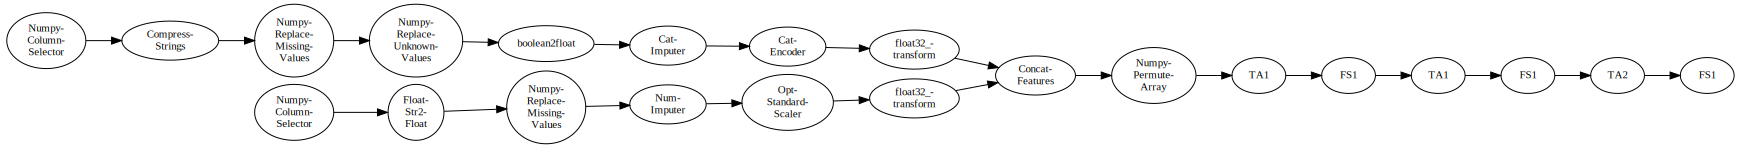

In [15]:
prefix = pipeline_model.remove_last().freeze_trainable()
prefix.visualize()

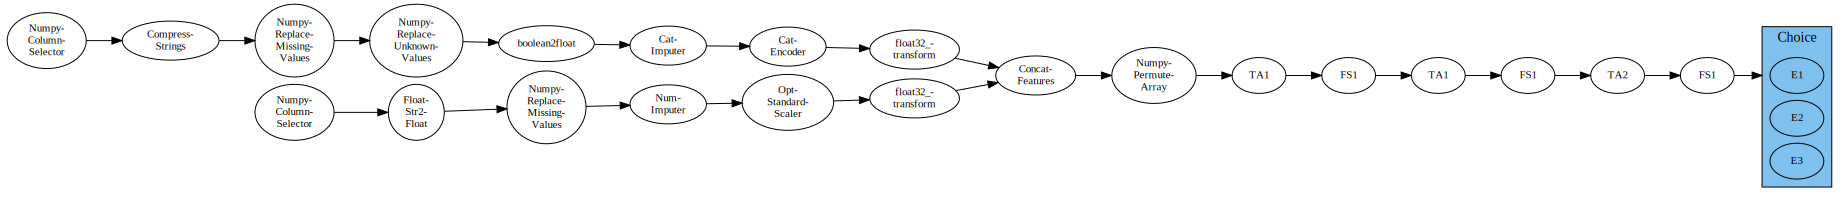

In [16]:
new_pipeline = prefix >> (E1 | E2 | E3)
new_pipeline.visualize()

<a id="new_optimizer"></a>
#### New optimizer `hyperopt` configuration and training

This section can introduce other results than the original one and it should be used
by more advanced users.

New pipeline is re-trained by passing train data to it and calling `fit` method.

Following cell performs dataset split for refined pipeline model.

In [20]:
from sklearn.model_selection import train_test_split

train_X = train_df.drop([experiment_metadata['prediction_column']], axis=1).values
train_y = train_df[experiment_metadata['prediction_column']].values

train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=experiment_metadata['test_size'],
                                                    stratify=train_y, random_state=experiment_metadata['random_state'])

In [21]:
hyperopt = Hyperopt(estimator=new_pipeline, cv=3, max_evals=20)
fitted_hyperopt = hyperopt.fit(train_X, train_y)

100%|██████████| 20/20 [03:43<00:00, 11.91s/trial, best loss: -0.7033333333333333]


In [22]:
hyperopt_pipeline = fitted_hyperopt.get_pipeline()
new_pipeline = hyperopt_pipeline.export_to_sklearn_pipeline()

In [23]:
prediction = new_pipeline.predict(test_X)

In [24]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_true=test_y, y_pred=prediction)
print('accuracy_score: ', score)

accuracy_score:  0.7


<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

<a id="wml_credentials"></a>
### Connection to WML
Authenticate the Watson Machine Learning service on IBM Cloud.

**Tip**: Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**Note:** You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` in the following cell.

In [14]:
api_key = ""

wml_credentials = {
  "apikey": api_key,
  "url": experiment_metadata["deployment_url"]
}

<a id="deployment"></a>

### Create deployment
 **Action**: If you want to deploy refined pipeline please change the `pipeline_model` to
`new_pipeline`.
If you prefer you can also change the `deployment_name`.
To perform deployment please specify `target_space_id`


In [15]:
target_space_id = ""

from ibm_watson_machine_learning.deployment import WebService
service = WebService(target_wml_credentials=wml_credentials,
                     target_space_id=target_space_id)
service.create(
model=pipeline_model,
metadata=experiment_metadata,
deployment_name=f'{pipeline_name}_webservice'
)

Preparing an AutoAI Deployment...
Depreciation Warning: Passing an object will no longer be supported. Please specify the AutoAI model name to deploy.
Published model uid: b74fcb43-0518-4b6b-8ad9-64d8f218e9e9
Deploying model b74fcb43-0518-4b6b-8ad9-64d8f218e9e9 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: 'b74fcb43-0518-4b6b-8ad9-64d8f218e9e9' started

#######################################################################################


initializing.....
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='288f00a2-58b8-4e71-9d7f-fa373904d34a'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [16]:
print(service)

name: Pipeline_4_webservice, id: 288f00a2-58b8-4e71-9d7f-fa373904d34a, scoring_url: https://us-south.ml.cloud.ibm.com/ml/v4/deployments/288f00a2-58b8-4e71-9d7f-fa373904d34a/predictions, asset_id: b74fcb43-0518-4b6b-8ad9-64d8f218e9e9


To be able to show all available information about deployment use `.get_params()` method:

In [ ]:
service.get_params()

<a id="online_scoring"></a>
### Score webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [18]:
predictions = service.score(payload=test_df)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [[2, [0.09972959756851196, 0.900270402431488]],
    [1, [0.9898703694343567, 0.010129603557288647]],
    [1, [0.8831580877304077, 0.11684193462133408]],
    [1, [0.9098848104476929, 0.09011518210172653]],
    [1, [0.8500241637229919, 0.14997585117816925]]]}]}

If you want to work with the webservice in external Python application you can retrieve the service object by:
 - initialize service by:
```
 service = WebService(target_wml_credentials=wml_credentials,
                      target_space_id=target_space_id)
```
 - get deployment_id by `service.list()` method
 - get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

<a id="delete_deployment"></a>
### Delete deployment

You can delete an existing deployment by calling `service.delete()`.

<a id="authors"></a>
### Authors

Licensed Materials - Copyright © 2020 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BHU2B7&title=IBM%20Watson%20Studio%20Auto-generated%20Notebook%20V2.1">License Terms</a>  

___